## Лабораторна робота 3. Побудова автокодувальника
### Завдання 2
### Блінда Ірина ФІТ 4-4

Розробитии варіаційний автокодувальник для датасету рукописних цифр MNIST на основі багатошарової моделі. 

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Завантаження та підготовка даних MNIST

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

 Визначення архітектури VAE

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 40) # 20 for mu and 20 for log_var
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(-1, 784)
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

Функція втрат і тренування моделі

In [4]:
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    losses.append(train_loss / len(train_loader.dataset))
    print(f'Epoch: {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

for epoch in range(1, 11):
    train(epoch)

Epoch: 1, Loss: 135.49282505696615
Epoch: 2, Loss: 113.21027561848959
Epoch: 3, Loss: 110.1288007446289
Epoch: 4, Loss: 108.71138233235678
Epoch: 5, Loss: 107.79941584065755
Epoch: 6, Loss: 107.19450540364583
Epoch: 7, Loss: 106.7767828531901
Epoch: 8, Loss: 106.29469643554687
Epoch: 9, Loss: 105.99181787923177
Epoch: 10, Loss: 105.71828012288411


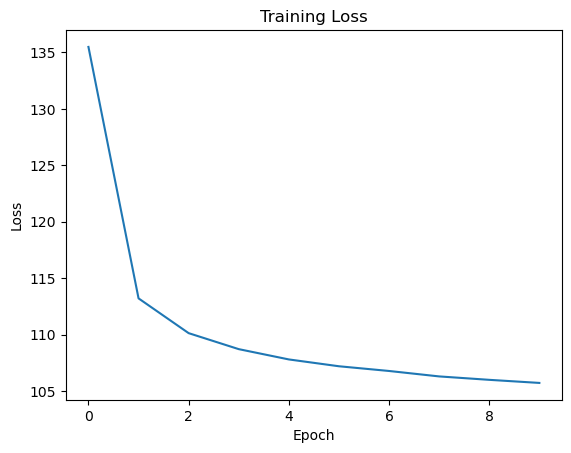

In [5]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Візуалізація результатів

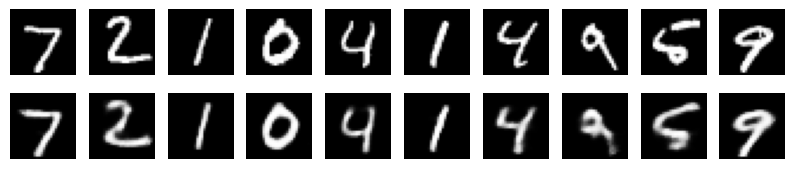

In [6]:
def test():
    model.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            recon, _, _ = model(data)
            break # Беремо лише перший батч для візуалізації

    fig, ax = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        ax[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
        ax[0, i].axis('off')
        ax[1, i].imshow(recon[i].reshape(28, 28), cmap='gray')
        ax[1, i].axis('off')
    plt.show()

test()

## Висновок 
У даній роботі був розроблений варіаційний автоенкодер (VAE) для набору даних рукописних цифр MNIST з використанням багатошарової моделі в середовищі PyTorch.

Перші етапи включали в себе підготовку даних MNIST, визначення архітектури VAE з енкодером та декодером, а також визначення функції втрат. Після цього модель була навчена на тренувальному наборі даних, і результати були візуалізовані на тестовому наборі.

Після тренування моделі було проведено візуалізацію реконструйованих зображень поряд з оригінальними для перевірки якості реконструкції. Результати показали, що VAE може успішно відтворювати рукописні цифри з датасету MNIST та генерувати нові зображення з використанням латентного простору.

У даній роботі було відображено процес побудови та тренування варіаційного автоенкодера для завдання реконструкції та генерації зображень. Це може слугувати основою для подальших досліджень у сфері глибокого навчання та генеративних моделей.